# **Image Compression Using 2D FFT**

## **Introduction**

This project demonstrates how to compress an image using the 2D Fast Fourier Transform (FFT). 
The FFT allows us to represent an image in the frequency domain, where we can analyze spatial frequencies 
and identify their contributions to the image's overall structure and detail.

### Project Goals:
1. Transform an image into the frequency domain using a 2D FFT.
2. Analyze and filter frequencies to identify low, medium, and high-frequency contributions.
3. Reconstruct the image from filtered frequencies and evaluate the trade-offs between compression and quality.
4. Explore energy contributions across different frequency bands and visualize the compression-quality relationship.

This aligns with the project description by employing frequency domain analysis and connecting it to practical applications 
like image compression and reconstruction.


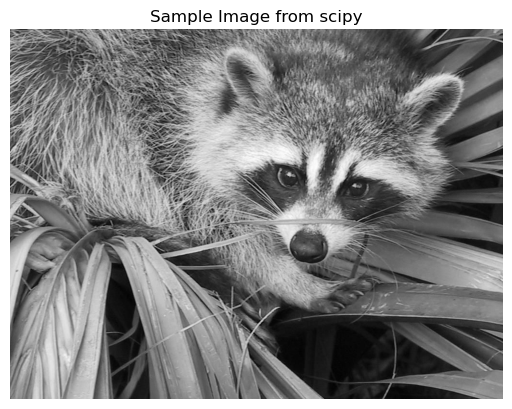

In [18]:
from scipy import datasets
import matplotlib.pyplot as plt

image = datasets.face(gray=True)  # Grayscale version
plt.imshow(image, cmap='gray')
plt.title("Sample Image from scipy")
plt.axis('off')
plt.show()



### Importing Libraries and Loading the Image

We use the following libraries:
- `numpy` and `scipy`: For numerical computations and FFT operations.
- `matplotlib`: For visualizing the image and frequency spectrum.
- `Pillow` (PIL): For image loading and processing.

The image used is a built-in test image from `scipy`, converted to grayscale to simplify the frequency analysis.
Grayscale reduces complexity by focusing on luminance variations instead of color.


In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fft import fft2, ifft2, fftshift, ifftshift


## **Performing the 2D FFT**

The 2D FFT converts the spatial representation of the image into the frequency domain. 
In this domain:
- **Low frequencies** (near the center of the spectrum) represent broad structures and gradual intensity changes.
- **High frequencies** (away from the center) represent fine details and sharp transitions.

Visualizing the magnitude spectrum of the FFT helps us understand how different frequencies contribute to the image.

Here’s the **markdown content** for the section on the mathematics of the 2D FFT:

---

## **Mathematics of the 2D FFT**

The 2D Fast Fourier Transform (FFT) is a mathematical tool used to transform a signal (or image) from the spatial domain into the frequency domain. In the frequency domain, the image is represented as a combination of sinusoidal components of varying frequencies and amplitudes.

### **The Forward 2D FFT**

The forward 2D FFT of an image $f(x, y) $ is defined as:

$$
F(u, v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) \cdot e^{-2\pi i \left( \frac{ux}{M} + \frac{vy}{N} \right)}
$$

Where:
- $ f(x, y) $: The image in the spatial domain.
- $ F(u, v) $: The image in the frequency domain.
- $ M, N $: The dimensions of the image (height and width).
- $ u, v $: The frequency coordinates in the transformed domain.
- $ e^{-2\pi i \left( \frac{ux}{M} + \frac{vy}{N} \right)} $: The complex exponential representing a sinusoidal basis function.

This operation decomposes the spatial domain image into a sum of sinusoidal components with varying frequencies and amplitudes.

---

### **The Inverse 2D FFT**

The inverse 2D FFT reconstructs the spatial domain image from its frequency domain representation. It is defined as:

$$
f(x, y) = \frac{1}{MN} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} F(u, v) \cdot e^{2\pi i \left( \frac{ux}{M} + \frac{vy}{N} \right)}
$$

Where:
- The scaling factor $ \frac{1}{MN} $ ensures that the amplitudes are normalized when transforming back to the spatial domain.
- The summation over all frequency components $ F(u, v) $ reconstructs the original image.

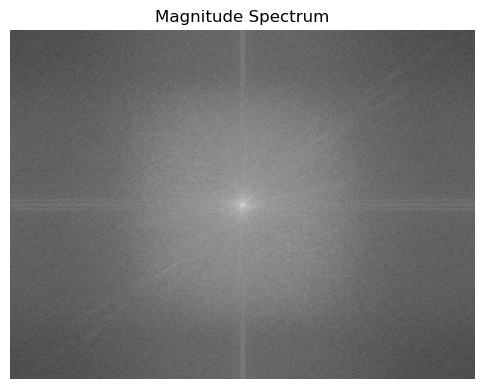

In [4]:
# Perform 2D FFT
fft_image = fft2(image)
fft_image_shifted = fftshift(fft_image)  # Shift zero frequency component to the center

# Compute the magnitude spectrum for visualization
magnitude_spectrum = np.log(np.abs(fft_image_shifted) + 1)  # Log scale for better visibility

# Display the magnitude spectrum
plt.figure(figsize=(6, 6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Magnitude Spectrum")
plt.axis('off')
plt.show()



## Filtering Frequencies with a Mask

We apply a mask to the frequency spectrum to selectively retain certain frequencies. 
This allows us to explore the role of different frequency bands (low, medium, high) in image reconstruction.

- **Low frequencies** capture overall structure and large patterns.
- **Medium frequencies** enhance edges and intermediate details.
- **High frequencies** refine fine details but may include noise.

The size of the mask determines which frequencies are retained. Smaller masks retain fewer frequencies, leading to higher compression but lower quality.


In [19]:
# Create a mask to filter frequencies
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2  # Find the center of the frequency spectrum

# Define the mask size
mask_size = 50  # Keep a square region of 50x50 frequencies
mask = np.zeros((rows, cols))
mask[crow-mask_size:crow+mask_size, ccol-mask_size:ccol+mask_size] = 1

# Apply the mask to the FFT-shifted image
filtered_fft = fft_image_shifted * mask


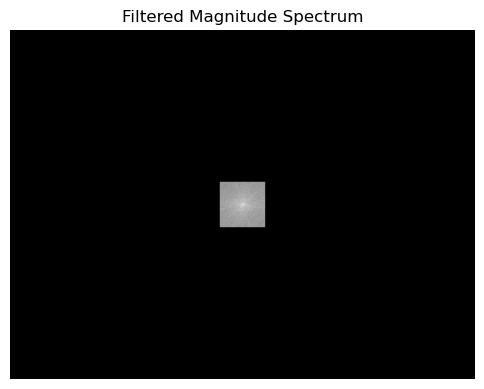

In [20]:
# Compute the magnitude spectrum after filtering
filtered_magnitude_spectrum = np.log(np.abs(filtered_fft) + 1)

# Display the filtered magnitude spectrum
plt.figure(figsize=(6, 6))
plt.imshow(filtered_magnitude_spectrum, cmap='gray')
plt.title("Filtered Magnitude Spectrum")
plt.axis('off')
plt.show()



## Reconstructing the Image

The inverse FFT (IFFT) transforms the filtered frequency components back into the spatial domain, producing the reconstructed image.

### Observations:
- Retaining only low frequencies reconstructs the broad structure of the image but lacks sharpness.
- Adding medium and high frequencies progressively restores details.
- The difference between the original and reconstructed images depends on the mask size and the frequencies removed.


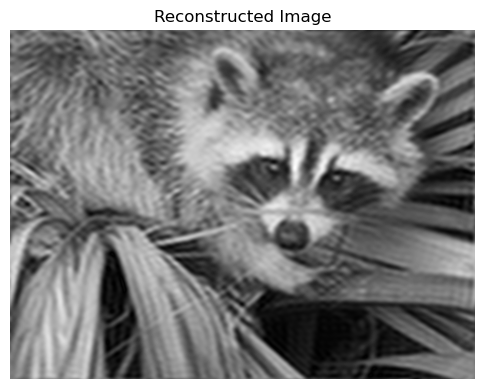

In [21]:
# Perform inverse FFT to reconstruct the image
filtered_fft_shifted_back = ifftshift(filtered_fft)  # Shift zero frequency back to the original position
reconstructed_image = np.abs(ifft2(filtered_fft_shifted_back))  # Take the absolute value

# Display the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()



## Calculating and Evaluating Compression

The **compression ratio** measures the fraction of frequencies retained after applying the mask:
$$ \text{Compression Ratio} = \frac{\text{Retained Frequencies}}{\text{Total Frequencies}} $$


Key metrics:
- **Compression Ratio**: Higher ratios mean fewer frequencies retained, resulting in smaller data size but lower quality.
- **Mean Squared Error (MSE)**: Quantifies the difference between the original and reconstructed images.

Balancing these metrics is critical for effective compression.


In [22]:
# Calculate the compression ratio
total_frequencies = rows * cols
retained_frequencies = np.sum(mask)
compression_ratio = retained_frequencies / total_frequencies

print(f"Total Frequencies: {total_frequencies}")
print(f"Retained Frequencies: {retained_frequencies}")
print(f"Compression Ratio: {compression_ratio:.2%}")

# Calculate Mean Squared Error (MSE) between original and reconstructed images
mse = np.mean((image - reconstructed_image) ** 2)
print(f"Mean Squared Error (MSE): {mse:.2f}")


Total Frequencies: 786432
Retained Frequencies: 10000.0
Compression Ratio: 1.27%
Mean Squared Error (MSE): 371.36


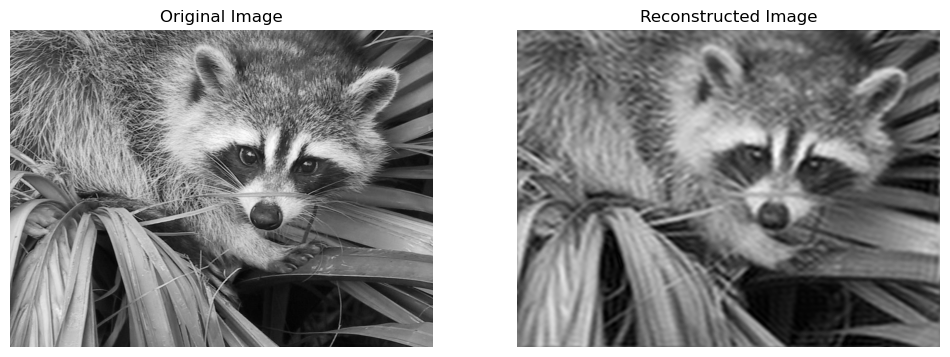

In [23]:
# Compare the original and reconstructed images side-by-side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()



## Energy Contribution by Frequency Band

Natural images typically have most of their energy concentrated in low frequencies. 
This analysis divides the frequency spectrum into three bands (low, medium, and high) to calculate their energy contributions.

### Observations:
- **Low frequencies** dominate the energy, capturing the majority of the image's structure.
- **Medium frequencies** contribute to edge details.
- **High frequencies** add fine details but have minimal energy, often associated with noise.


In [12]:
# Calculate the total energy in the spectrum
total_energy = np.sum(np.abs(fft_image_shifted) ** 2)

# Create masks for low, medium, and high frequencies
low_freq_mask = np.zeros_like(fft_image_shifted)
medium_freq_mask = np.zeros_like(fft_image_shifted)
high_freq_mask = np.zeros_like(fft_image_shifted)

# Define regions (adjust these ranges as needed)
crow, ccol = rows // 2, cols // 2
radius_low = 20
radius_medium = 50

# Low frequencies (center)
low_freq_mask[crow-radius_low:crow+radius_low, ccol-radius_low:ccol+radius_low] = 1

# Medium frequencies (surrounding low frequencies)
medium_freq_mask[crow-radius_medium:crow+radius_medium, ccol-radius_medium:ccol+radius_medium] = 1
medium_freq_mask -= low_freq_mask  # Exclude low frequencies

# High frequencies (remaining)
high_freq_mask = 1 - (low_freq_mask + medium_freq_mask)

# Calculate energy contributions
low_energy = np.sum(np.abs(fft_image_shifted * low_freq_mask) ** 2) / total_energy
medium_energy = np.sum(np.abs(fft_image_shifted * medium_freq_mask) ** 2) / total_energy
high_energy = np.sum(np.abs(fft_image_shifted * high_freq_mask) ** 2) / total_energy

print(f"Energy Contribution by Frequency Band:")
print(f"Low Frequencies: {low_energy:.2%}")
print(f"Medium Frequencies: {medium_energy:.2%}")
print(f"High Frequencies: {high_energy:.2%}")


Energy Contribution by Frequency Band:
Low Frequencies: 95.97%
Medium Frequencies: 1.68%
High Frequencies: 2.35%


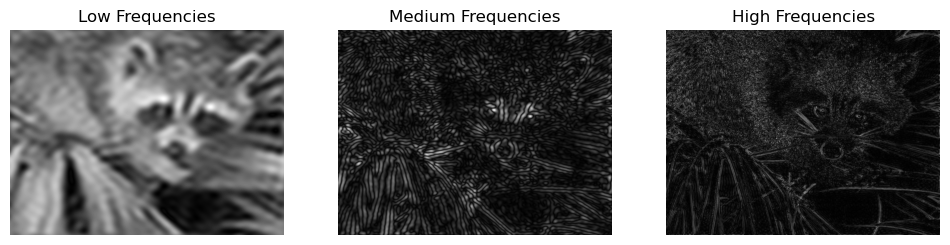

In [13]:
# Function to reconstruct an image with a given mask
def reconstruct_with_mask(fft_shifted, mask):
    filtered_fft = fft_shifted * mask
    filtered_shifted_back = ifftshift(filtered_fft)
    return np.abs(ifft2(filtered_shifted_back))

# Reconstruct images
low_image = reconstruct_with_mask(fft_image_shifted, low_freq_mask)
medium_image = reconstruct_with_mask(fft_image_shifted, medium_freq_mask)
high_image = reconstruct_with_mask(fft_image_shifted, high_freq_mask)

# Display images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(low_image, cmap='gray')
plt.title("Low Frequencies")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(medium_image, cmap='gray')
plt.title("Medium Frequencies")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(high_image, cmap='gray')
plt.title("High Frequencies")
plt.axis('off')

plt.show()



## Exploring Compression Trade-offs

By varying the size of the frequency mask, we can explore how the compression ratio affects image quality.
Larger masks retain more frequencies, leading to better quality but lower compression.

Metrics to analyze:
- **Compression Ratio**: How much data is retained.
- **Mean Squared Error (MSE)**: How much the reconstructed image deviates from the original.


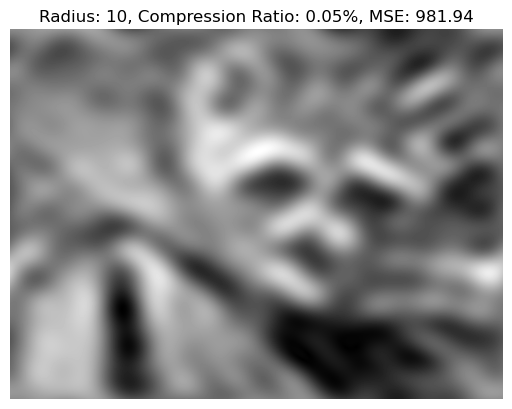

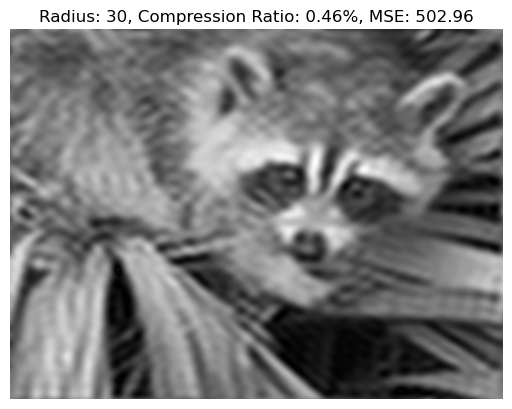

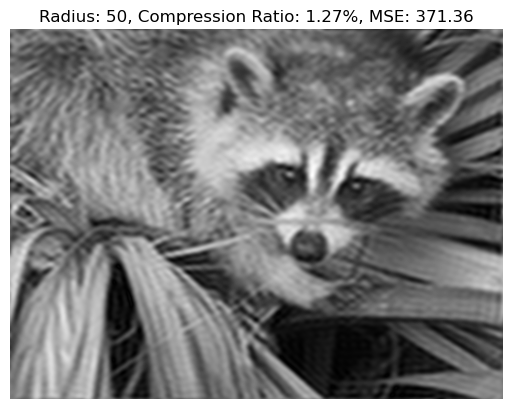

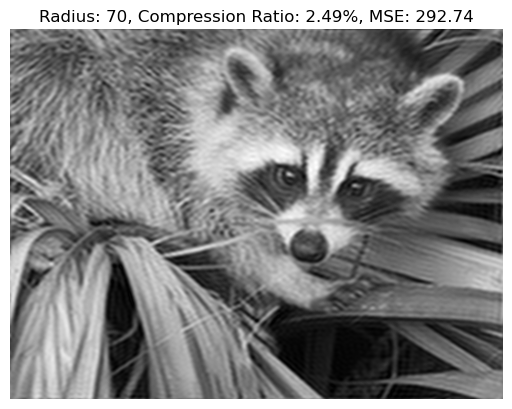

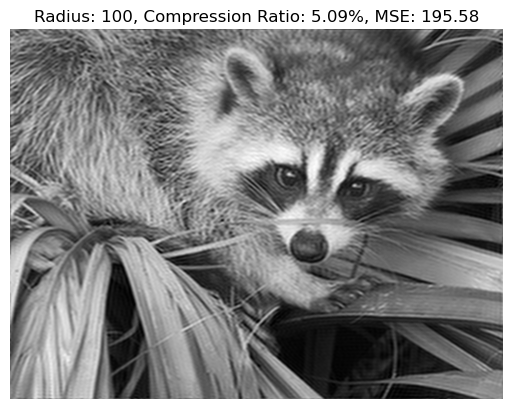

Radius | Compression Ratio | MSE
    10 | 0.05%              | 981.94
    30 | 0.46%              | 502.96
    50 | 1.27%              | 371.36
    70 | 2.49%              | 292.74
   100 | 5.09%              | 195.58


In [16]:
# Function to apply a circular mask and calculate metrics
def compress_and_evaluate(radius):
    mask = np.zeros((rows, cols))
    mask[crow-radius:crow+radius, ccol-radius:ccol+radius] = 1
    filtered_fft = fft_image_shifted * mask
    filtered_shifted_back = ifftshift(filtered_fft)
    reconstructed = np.abs(ifft2(filtered_shifted_back))
    
    # Calculate metrics
    retained_frequencies = np.sum(mask)
    compression_ratio = retained_frequencies / total_frequencies
    mse = np.mean((image - reconstructed) ** 2)
    
    return reconstructed, compression_ratio, mse

# Evaluate for different radii
radii = [10, 30, 50, 70, 100]
results = []

for r in radii:
    reconstructed, compression_ratio, mse = compress_and_evaluate(r)
    results.append((r, compression_ratio, mse))
    
    # Display reconstructed image
    plt.figure()
    plt.imshow(reconstructed, cmap='gray')
    plt.title(f"Radius: {r}, Compression Ratio: {compression_ratio:.2%}, MSE: {mse:.2f}")
    plt.axis('off')
    plt.show()

# Summarize results
print("Radius | Compression Ratio | MSE")
for r, cr, mse in results:
    print(f"{r:6} | {cr:.2%}              | {mse:.2f}")



## Visualizing Compression Trade-offs

A plot of Compression Ratio vs. MSE highlights the trade-offs:
- Higher compression ratios (smaller masks) result in greater loss of detail and higher MSE.
- Lower compression ratios (larger masks) preserve image quality but require more storage.

This visualization helps identify the optimal balance for specific applications.


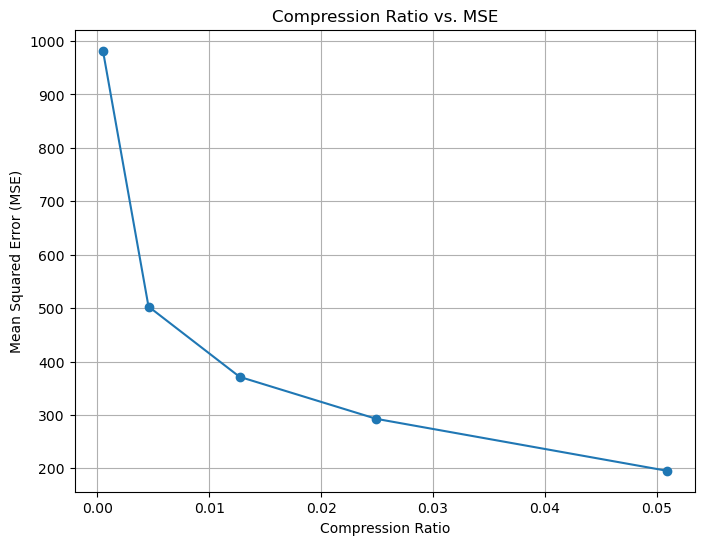

In [17]:
# Generate a plot of MSE vs. Compression Ratio
radii = [10, 30, 50, 70, 100]
compression_ratios = [r[1] for r in results]
mses = [r[2] for r in results]

plt.figure(figsize=(8, 6))
plt.plot(compression_ratios, mses, marker='o')
plt.xlabel("Compression Ratio")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Compression Ratio vs. MSE")
plt.grid()
plt.show()


### **References**

1. Demofox. *Frequency Domain Image Compression and Filtering*. (2020).  
   Available at: [https://blog.demofox.org/2020/11/04/frequency-domain-image-compression-and-filtering/](https://blog.demofox.org/2020/11/04/frequency-domain-image-compression-and-filtering/)  
   - Discusses the application of Fourier transforms for image compression and filtering, with clear explanations and practical examples.

2. University of Edinburgh. *The Fourier Transform and Its Applications in Image Processing*.  
   Available at: [https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm](https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm)  
   - A detailed tutorial on the Fourier transform, its properties, and its use in image processing.

3. SciPy Documentation. *Fast Fourier Transform (FFT)*.  
   Available at: [https://docs.scipy.org/doc/scipy/reference/fft.html](https://docs.scipy.org/doc/scipy/reference/fft.html)  
   - Provides practical guidance for implementing FFT using the SciPy library in Python.